In [16]:
#import dependencies
import os
import csv
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data Import Cleaning

In [17]:
# Step 1: Load and Clean Data
# Load the data
file_path = 'C:/Users/a3588/Documents/GitHub/forecasting-ad-spend-leads/Resources/updated_combined_leads_app_data.csv'
data = pd.read_csv(file_path)

In [18]:
# Remove currency symbols and commas, then convert to float
data['Cost'] = data['Cost'].str.replace('$', '').str.replace(',', '').astype(float)
data['Lead_ID Count'] = data['Lead_ID Count'].astype(float)
data['Applications'] = data['Applications'].astype(float)
data['Clicks'] = data['Clicks'].astype(float)
data['Impressions'] = data['Impressions'].astype(float)

In [19]:
# Step 2: Feature Engineering
# Seasonal Features
data['Month_Num'] = pd.Categorical(data['Month'], 
    categories=['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December'],
    ordered=True).codes + 1
data['Month_sin'] = np.sin(2 * np.pi * data['Month_Num'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month_Num'] / 12)

# Lag and Rolling Features
for col in ['Cost', 'Lead_ID Count', 'Applications']:
    # Lag features
    data[f'{col}_lag_1'] = data[col].shift(1)
    # Rolling features
    data[f'{col}_rolling_3'] = data[col].rolling(window=3).mean()
    data[f'{col}_rolling_6'] = data[col].rolling(window=6).mean()

# Performance Metrics
data['Conversion_Rate'] = data['Lead_ID Count'] / data['Clicks']
data['Cost_Per_Lead'] = data['Cost'] / data['Lead_ID Count']
data['CPC'] = data['Cost'] / data['Clicks']
data['Lead_to_Application_Rate'] = data['Applications'] / data['Lead_ID Count']
data['Cost_per_Application'] = data['Cost'] / data['Applications']
data['Application_Conversion_Rate'] = data['Applications'] / data['Clicks']

# Efficiency Metrics
data['Lead_Quality_Score'] = data['Applications'] / data['Lead_ID Count']
data['Cost_Efficiency'] = data['Applications'] / data['Cost']

# Lag features for rates
data['Conversion_Rate_lag_1'] = data['Conversion_Rate'].shift(1)
data['Cost_Per_Lead_lag_1'] = data['Cost_Per_Lead'].shift(1)
data['Lead_to_Application_Rate_lag_1'] = data['Lead_to_Application_Rate'].shift(1)

# Handle missing values and infinities
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='bfill', inplace=True)

C:\Users\a3588\AppData\Local\Temp\ipykernel_31632\1840232683.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [20]:
# Step 3: Prepare Data for Modeling
features = data[[
    'Year', 'Month_Num', 'Month_sin', 'Month_cos',
    'Cost_lag_1', 'Cost_rolling_3', 'Cost_rolling_6',
    'Lead_ID Count_lag_1', 'Lead_ID Count_rolling_3', 'Lead_ID Count_rolling_6',
    'Applications_lag_1', 'Applications_rolling_3', 'Applications_rolling_6',
    'Conversion_Rate', 'Cost_Per_Lead', 'CPC',
    'Lead_to_Application_Rate', 'Cost_per_Application', 'Application_Conversion_Rate',
    'Lead_Quality_Score', 'Cost_Efficiency',
    'Conversion_Rate_lag_1', 'Cost_Per_Lead_lag_1', 'Lead_to_Application_Rate_lag_1'
]]

targets_cost = data['Cost']
targets_leads = data['Lead_ID Count']
targets_applications = data['Applications']

# Split into training data (2023-2024) and future forecast (2025)
X_train = features[features['Year'] < 2025]
y_train_cost = targets_cost[features['Year'] < 2025]
y_train_leads = targets_leads[features['Year'] < 2025]
y_train_applications = targets_applications[features['Year'] < 2025]

# Forecast 2025

In [21]:
# Prepare forecast data
X_forecast = pd.DataFrame({
    'Year': [2025] * 12,
    'Month_Num': np.arange(1, 13),
    'Month_sin': np.sin(2 * np.pi * np.arange(1, 13) / 12),
    'Month_cos': np.cos(2 * np.pi * np.arange(1, 13) / 12)
})

# Fill forecast features with last known values
for col in features.columns:
    if col not in ['Year', 'Month_Num', 'Month_sin', 'Month_cos']:
        if '_rolling_' in col:
            # Extract the base column name (e.g., 'Cost' from 'Cost_rolling_3')
            base_col = col.split('_rolling_')[0]
            X_forecast[col] = data[data['Year'] == 2024][base_col].iloc[-3:].mean()
        elif '_lag_1' in col:
            # Extract the base column name (e.g., 'Cost' from 'Cost_lag_1')
            base_col = col.split('_lag_1')[0]
            X_forecast[col] = data[data['Year'] == 2024][base_col].iloc[-1]
        else:
            # For other columns (like Conversion_Rate, Cost_Per_Lead, etc.)
            X_forecast[col] = data[data['Year'] == 2024][col].iloc[-3:].mean()

In [22]:
# Train Models
model_cost = RandomForestRegressor(random_state=42, n_estimators=100)
model_leads = RandomForestRegressor(random_state=42, n_estimators=100)
model_applications = RandomForestRegressor(random_state=42, n_estimators=100)

model_cost.fit(X_train, y_train_cost)
model_leads.fit(X_train, y_train_leads)
model_applications.fit(X_train, y_train_applications)

# Generate Forecasts with growth adjustment
growth_factor = 1.6  # 40% growth adjustment
forecast_cost = model_cost.predict(X_forecast) * growth_factor
forecast_leads = model_leads.predict(X_forecast) * growth_factor
forecast_applications = model_applications.predict(X_forecast) * growth_factor

# Combine Results
forecast_data = pd.DataFrame({
    'Year': X_forecast['Year'],
    'Month': pd.Categorical(
        ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December'],
        categories=['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December'],
        ordered=True
    ),
    'Forecasted_Cost': forecast_cost,
    'Forecasted_Leads': forecast_leads,
    'Forecasted_Applications': forecast_applications
})

In [23]:
# Display results
print("\nForecast for 2025:")
print(forecast_data)

# Calculate and display metrics
print("\nFeature Importance for Cost Model:")
for feature, importance in zip(features.columns, model_cost.feature_importances_):
    print(f"{feature}: {importance:.4f}")

print("\nFeature Importance for Leads Model:")
for feature, importance in zip(features.columns, model_leads.feature_importances_):
    print(f"{feature}: {importance:.4f}")

print("\nFeature Importance for Applications Model:")
for feature, importance in zip(features.columns, model_applications.feature_importances_):
    print(f"{feature}: {importance:.4f}")




Forecast for 2025:
    Year      Month  Forecasted_Cost  Forecasted_Leads  \
0   2025    January      36261.68096          3482.272   
1   2025   February      36261.68096          3491.296   
2   2025      March      36262.76384          3503.312   
3   2025      April      35898.53600          3433.040   
4   2025        May      35052.26016          3424.880   
5   2025       June      34647.55808          3413.568   
6   2025       July      33921.33648          3417.040   
7   2025     August      35156.77248          3417.040   
8   2025  September      35836.92784          3423.232   
9   2025    October      35754.03088          3307.440   
10  2025   November      35757.22576          3309.168   
11  2025   December      35956.09264          3279.936   

    Forecasted_Applications  
0                   531.504  
1                   530.912  
2                   533.072  
3                   533.120  
4                   530.800  
5                   529.328  
6              

In [24]:
# Save results
forecast_data.to_csv('C:/Users/a3588/Documents/GitHub/forecasting-ad-spend-leads/Resources/forecasted_monthly_metrics_2025.csv', index=False)

# Display the forecasts
print("\nForecasted Monthly Metrics for 2025:")
print(forecast_data)


Forecasted Monthly Metrics for 2025:
    Year      Month  Forecasted_Cost  Forecasted_Leads  \
0   2025    January      36261.68096          3482.272   
1   2025   February      36261.68096          3491.296   
2   2025      March      36262.76384          3503.312   
3   2025      April      35898.53600          3433.040   
4   2025        May      35052.26016          3424.880   
5   2025       June      34647.55808          3413.568   
6   2025       July      33921.33648          3417.040   
7   2025     August      35156.77248          3417.040   
8   2025  September      35836.92784          3423.232   
9   2025    October      35754.03088          3307.440   
10  2025   November      35757.22576          3309.168   
11  2025   December      35956.09264          3279.936   

    Forecasted_Applications  
0                   531.504  
1                   530.912  
2                   533.072  
3                   533.120  
4                   530.800  
5                   529.328

# Model Accuray Analysis

In [25]:
# Calculate and Display Model Accuracy
def display_model_metrics(model, X, y, model_name):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    print(f"\n{model_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error: ${mae:,.2f}")
    print(f"Root Mean Squared Error: ${rmse:,.2f}")
    
    return y_pred

print("\nModel Performance Metrics (Training Data):")
y_pred_cost = display_model_metrics(model_cost, X_train, y_train_cost, "Cost Model")
y_pred_leads = display_model_metrics(model_leads, X_train, y_train_leads, "Leads Model")
y_pred_applications = display_model_metrics(model_applications, X_train, y_train_applications, "Applications Model")


Model Performance Metrics (Training Data):

Cost Model Metrics:
R² Score: 0.9369
Mean Absolute Error: $811.85
Root Mean Squared Error: $1,073.43

Leads Model Metrics:
R² Score: 0.9591
Mean Absolute Error: $156.12
Root Mean Squared Error: $187.90

Applications Model Metrics:
R² Score: 0.9276
Mean Absolute Error: $21.13
Root Mean Squared Error: $29.08


# Feature Importance Visualization

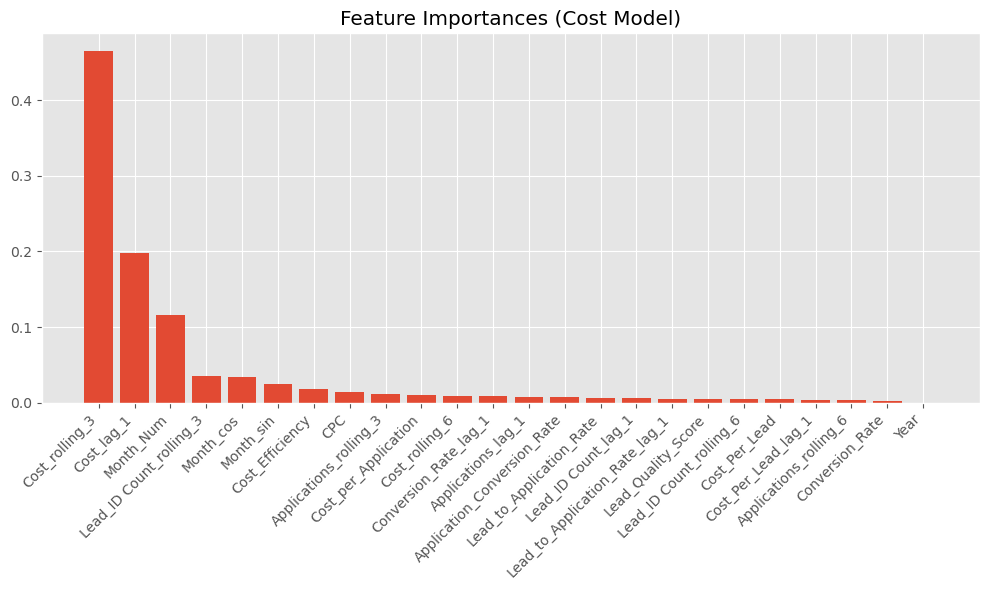

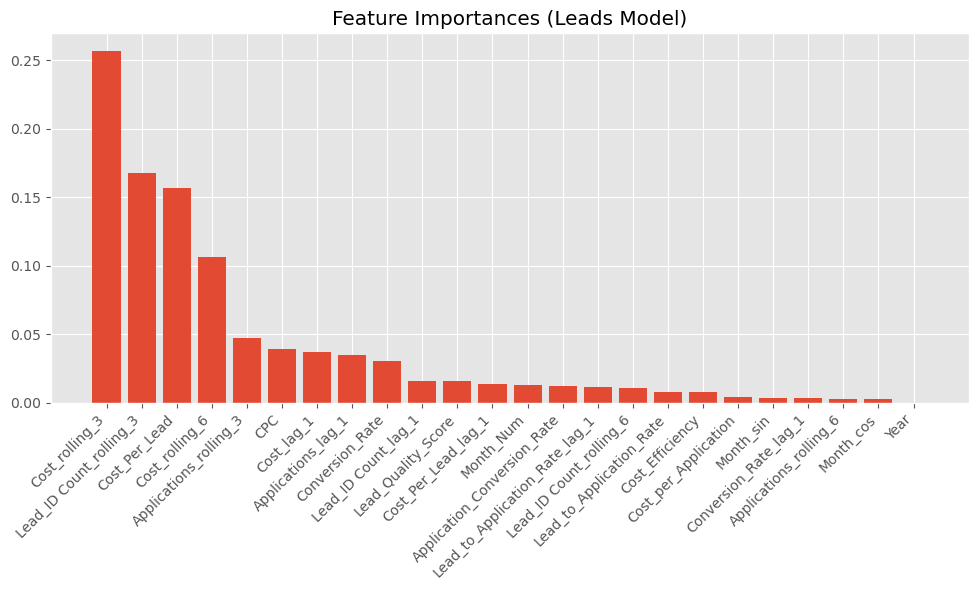

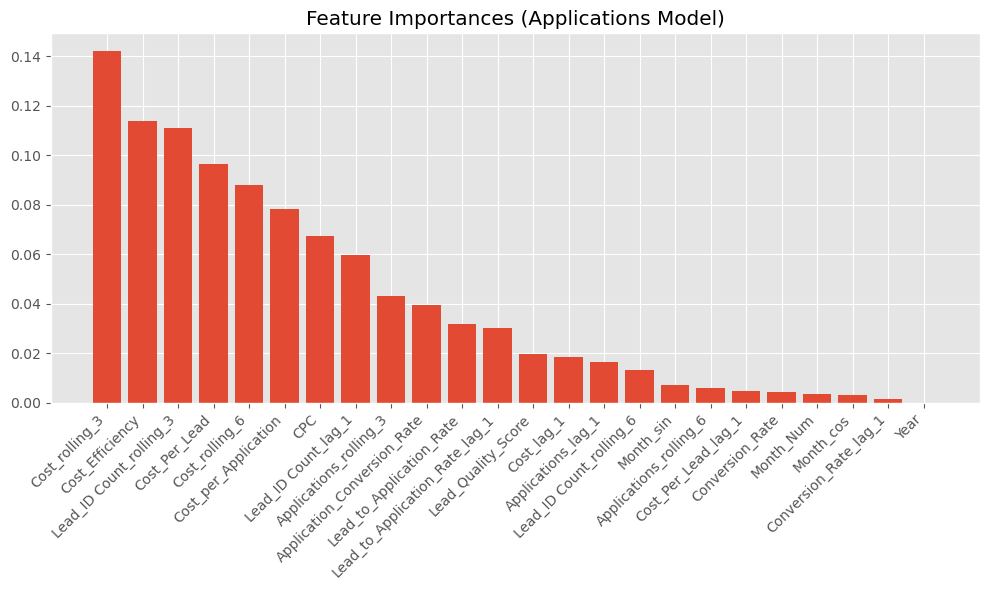

In [26]:
# Feature Importance Visualization
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances ({title})")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

feature_names = features.columns
plot_feature_importance(model_cost, feature_names, "Cost Model")
plot_feature_importance(model_leads, feature_names, "Leads Model")
plot_feature_importance(model_applications, feature_names, "Applications Model")


# Training Data Visualization

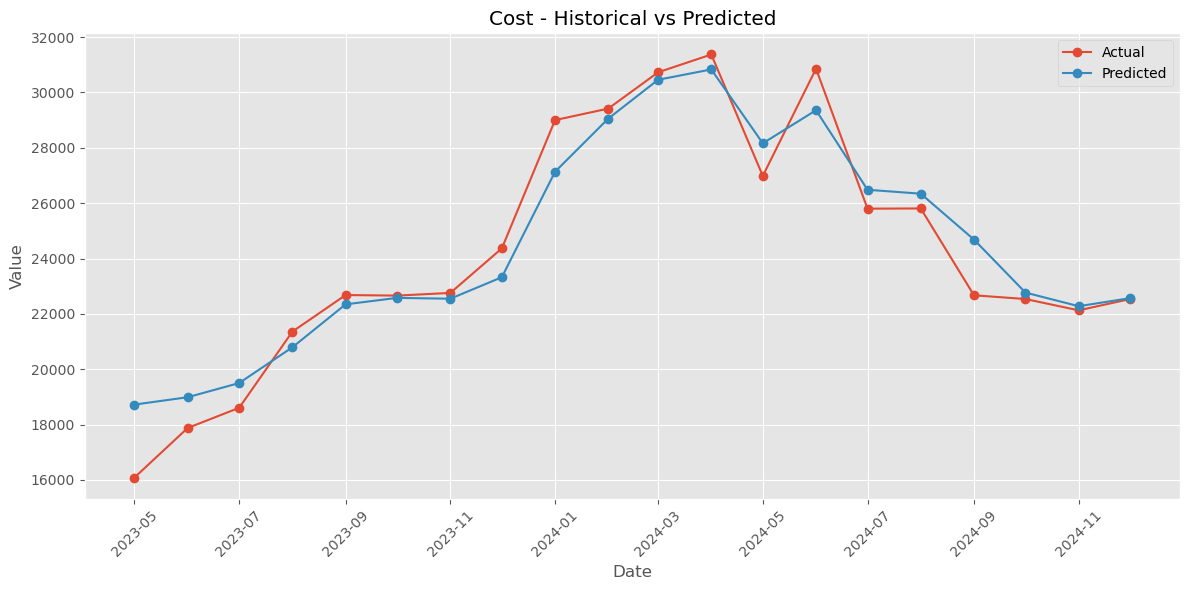

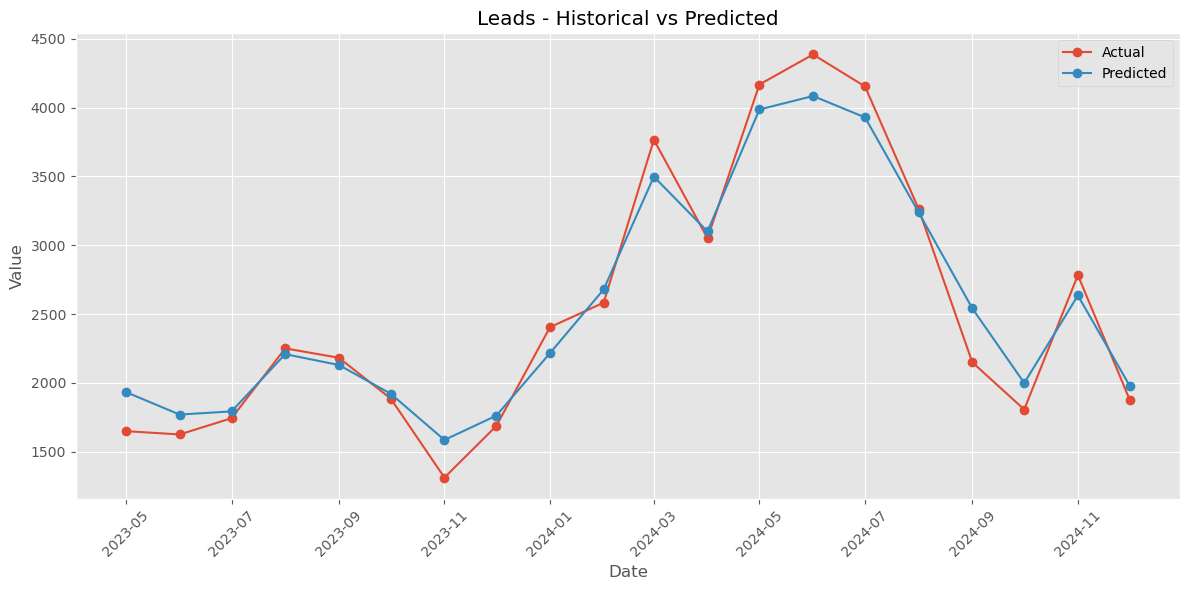

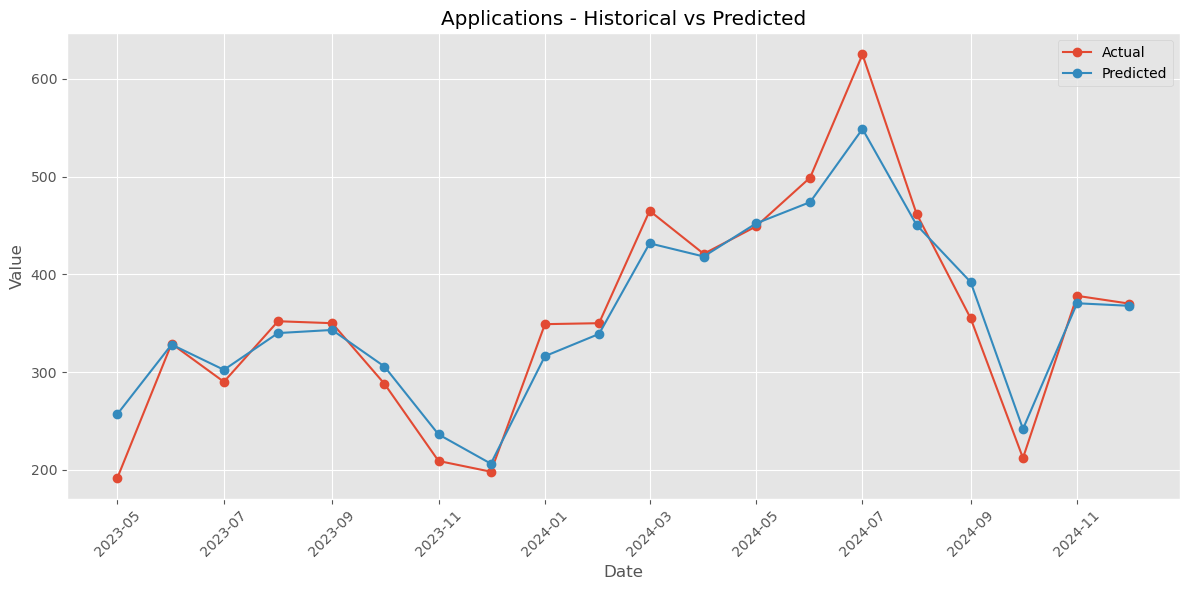

In [27]:
# Historical vs Predicted Values Visualization
historical_dates = pd.to_datetime(data[data['Year'] < 2025].apply(
    lambda x: f"{int(x['Year'])}-{int(x['Month_Num']):02d}-01", axis=1
))

def plot_historical_vs_predicted(actual, predicted, dates, title):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', marker='o')
    plt.plot(dates, predicted, label='Predicted', marker='o')
    plt.title(f'{title} - Historical vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_historical_vs_predicted(y_train_cost, y_pred_cost, historical_dates, 'Cost')
plot_historical_vs_predicted(y_train_leads, y_pred_leads, historical_dates, 'Leads')
plot_historical_vs_predicted(y_train_applications, y_pred_applications, historical_dates, 'Applications')

# 2025 Forecast Data Visualization

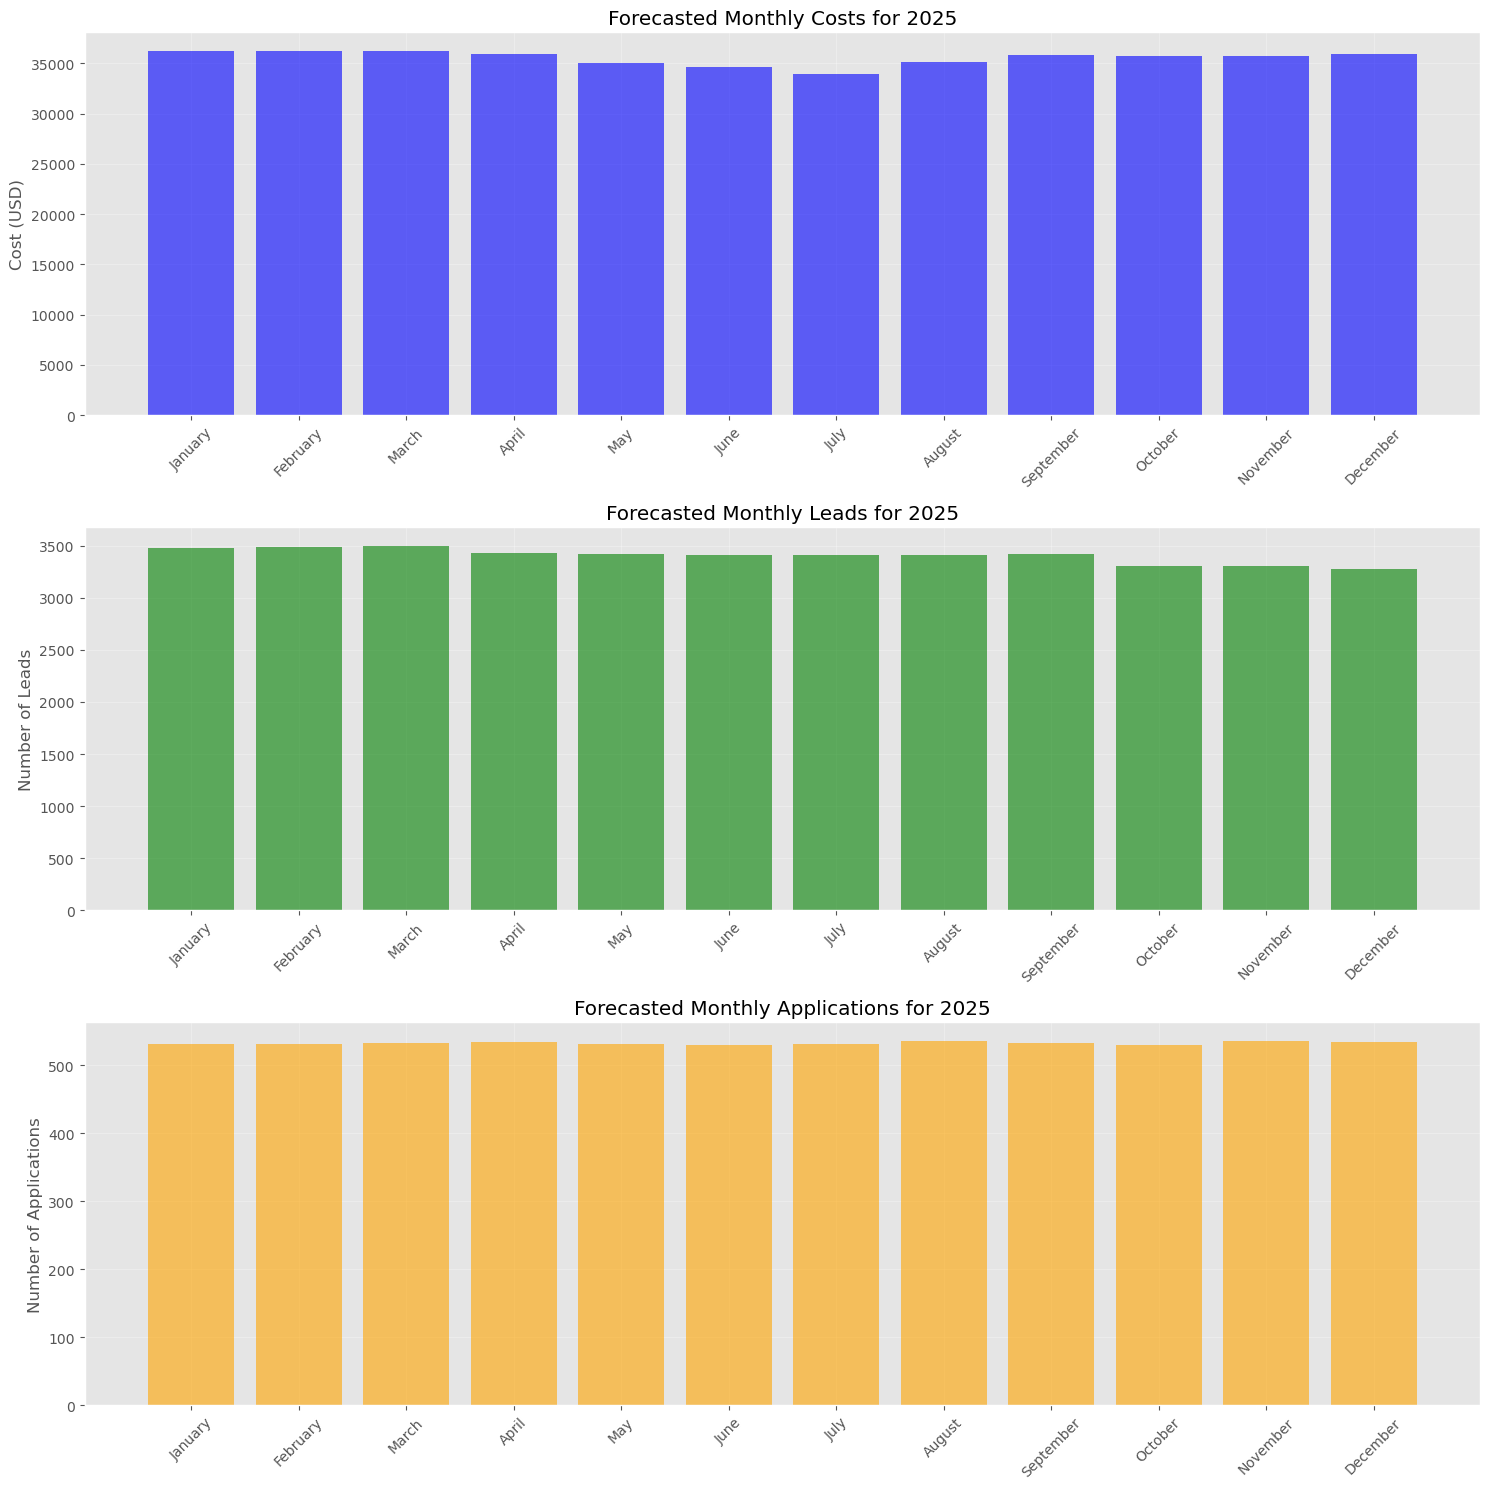

In [28]:
# 2025 Forecast Visualizations
plt.style.use('ggplot')  # Using 'ggplot' style instead of 'seaborn'

# Individual forecasts
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Cost Forecast
ax1.bar(forecast_data['Month'], forecast_data['Forecasted_Cost'], color='blue', alpha=0.6)
ax1.set_title('Forecasted Monthly Costs for 2025')
ax1.set_ylabel('Cost (USD)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Leads Forecast
ax2.bar(forecast_data['Month'], forecast_data['Forecasted_Leads'], color='green', alpha=0.6)
ax2.set_title('Forecasted Monthly Leads for 2025')
ax2.set_ylabel('Number of Leads')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Applications Forecast
ax3.bar(forecast_data['Month'], forecast_data['Forecasted_Applications'], color='orange', alpha=0.6)
ax3.set_title('Forecasted Monthly Applications for 2025')
ax3.set_ylabel('Number of Applications')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

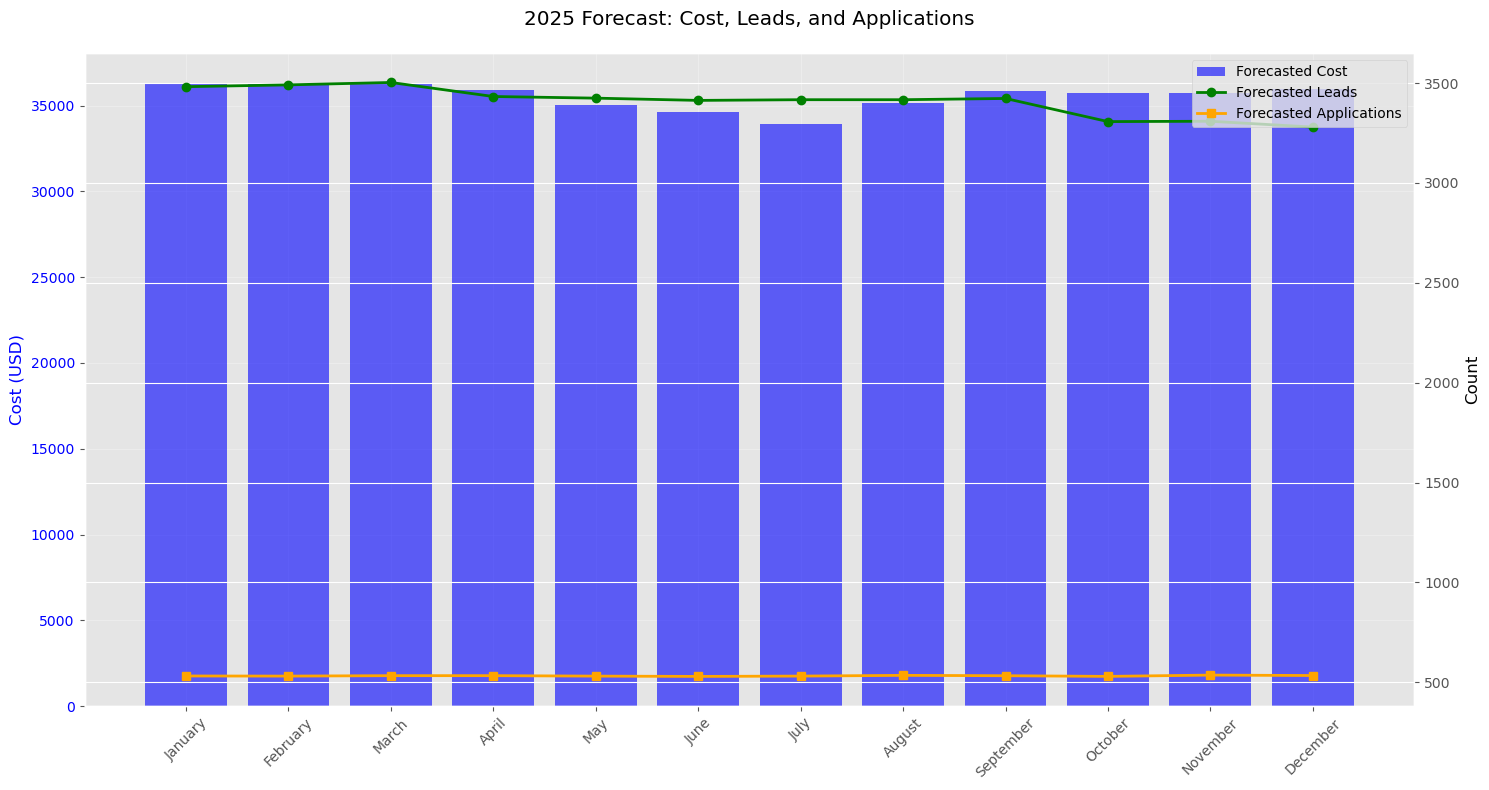

In [29]:
# Combined visualization
fig, ax1 = plt.subplots(figsize=(15, 8))

# Cost bars
bars = ax1.bar(forecast_data['Month'], forecast_data['Forecasted_Cost'], alpha=0.6, color='blue', label='Forecasted Cost')
ax1.set_ylabel('Cost (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Second y-axis for Leads and Applications
ax2 = ax1.twinx()

# Plot lines
line1 = ax2.plot(forecast_data['Month'], forecast_data['Forecasted_Leads'], 
                 color='green', marker='o', label='Forecasted Leads', linewidth=2)
line2 = ax2.plot(forecast_data['Month'], forecast_data['Forecasted_Applications'], 
                 color='orange', marker='s', label='Forecasted Applications', linewidth=2)
ax2.set_ylabel('Count', color='black')

# Title and formatting
plt.title('2025 Forecast: Cost, Leads, and Applications', pad=20)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Summary Statistics

In [30]:
# Print summary statistics
print("\n2025 Forecast Summary:")
print("Monthly Averages:")
print(f"Cost: ${forecast_data['Forecasted_Cost'].mean():,.2f}")
print(f"Leads: {forecast_data['Forecasted_Leads'].mean():,.0f}")
print(f"Applications: {forecast_data['Forecasted_Applications'].mean():,.0f}")

print("\nYearly Totals:")
print(f"Total Cost: ${forecast_data['Forecasted_Cost'].sum():,.2f}")
print(f"Total Leads: {forecast_data['Forecasted_Leads'].sum():,.0f}")
print(f"Total Applications: {forecast_data['Forecasted_Applications'].sum():,.0f}")


2025 Forecast Summary:
Monthly Averages:
Cost: $35,563.91
Leads: 3,409
Applications: 532

Yearly Totals:
Total Cost: $426,766.87
Total Leads: 40,902
Total Applications: 6,386
